In [170]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import utils.paths as path
import utils.data_cleaning
import missingno

In [171]:
data_dir = path.make_dir_function('data')

In [172]:
df_hurtos = pd.read_csv(data_dir('pre_process','hurtos.csv'),sep=',')
#nuevo df sin columnas innecesarias
df = df_hurtos.copy()
df.drop(['DIRECTORIO', 'NRO_ENCUESTA', 'SECUENCIA_ENCUESTA', 'SECUENCIA_P',
       'ORDEN', 'FEX_C','municipio'],axis=1,inplace=True)

In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16256 entries, 0 to 16255
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   mes_ultimo_unico_robo      16256 non-null  object
 1   metodo                     16256 non-null  object
 2   hora                       16111 non-null  object
 3   lugar                      16256 non-null  object
 4   celular                    16256 non-null  object
 5   efectivo_tarjetas          16256 non-null  object
 6   articulos_de_uso_personal  16256 non-null  object
 7   dispositivos               16256 non-null  object
 8   otra_pertenencia           16256 non-null  object
 9   arma_fuego                 13884 non-null  object
 10  arma_blanca                13884 non-null  object
 11  otros_objetos              13884 non-null  object
 12  fuerza_fisica              13884 non-null  object
 13  drogas_sustancias          13884 non-null  object
 14  hizo_l

# Valores faltantes

In [174]:
df.shape

(16256, 24)

In [175]:
#numero de valores faltantes
df.ms_tools.number_missing()

78680

In [176]:
df.ms_tools.number_complete()

311464

### ¿Qué valores faltantes tenemos por cada columna?

In [177]:
df.isnull().sum()

mes_ultimo_unico_robo            0
metodo                           0
hora                           145
lugar                            0
celular                          0
efectivo_tarjetas                0
articulos_de_uso_personal        0
dispositivos                     0
otra_pertenencia                 0
arma_fuego                    2372
arma_blanca                   2372
otros_objetos                 2372
fuerza_fisica                 2372
drogas_sustancias             2372
hizo_llamada                     0
denuncia                         0
lugar_denuncia               11117
autoridad                    11820
razon_denuncia               11116
buena_atencion               12655
razon_de_satisfaccion        14762
razon_no_denuncia             5205
recuperacion_objeto              0
year                             0
dtype: int64

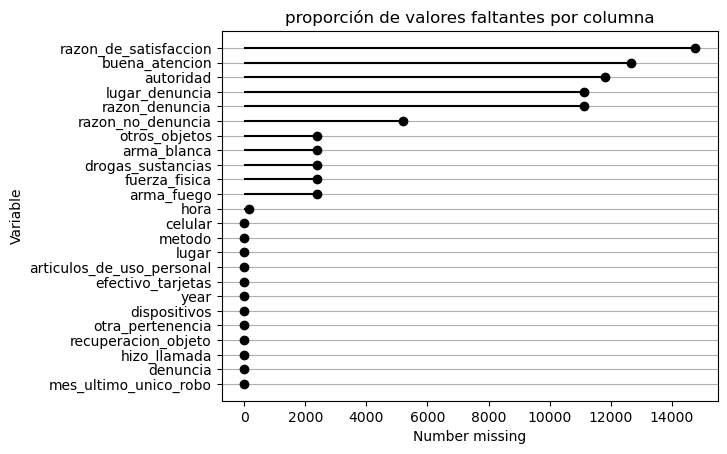

In [178]:
df.ms_tools.vis_variable_plot()
plt.title('proporción de valores faltantes por columna')
plt.show()

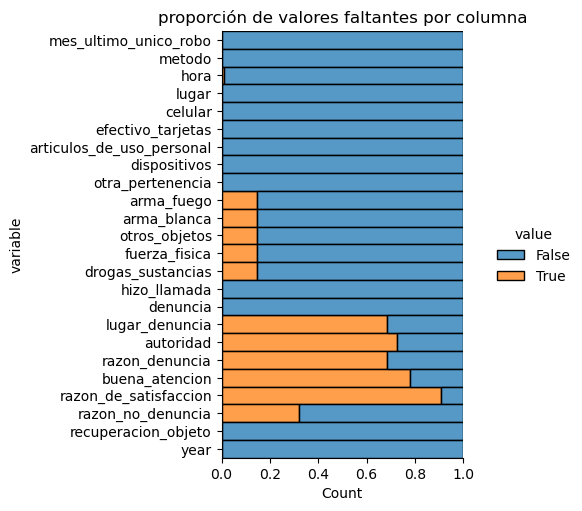

In [179]:
df.ms_tools.vis_proportion()
plt.title('proporción de valores faltantes por columna')
plt.show()

# ¿Qué razones pueden haber para que hayan valores faltantes?

<AxesSubplot: >

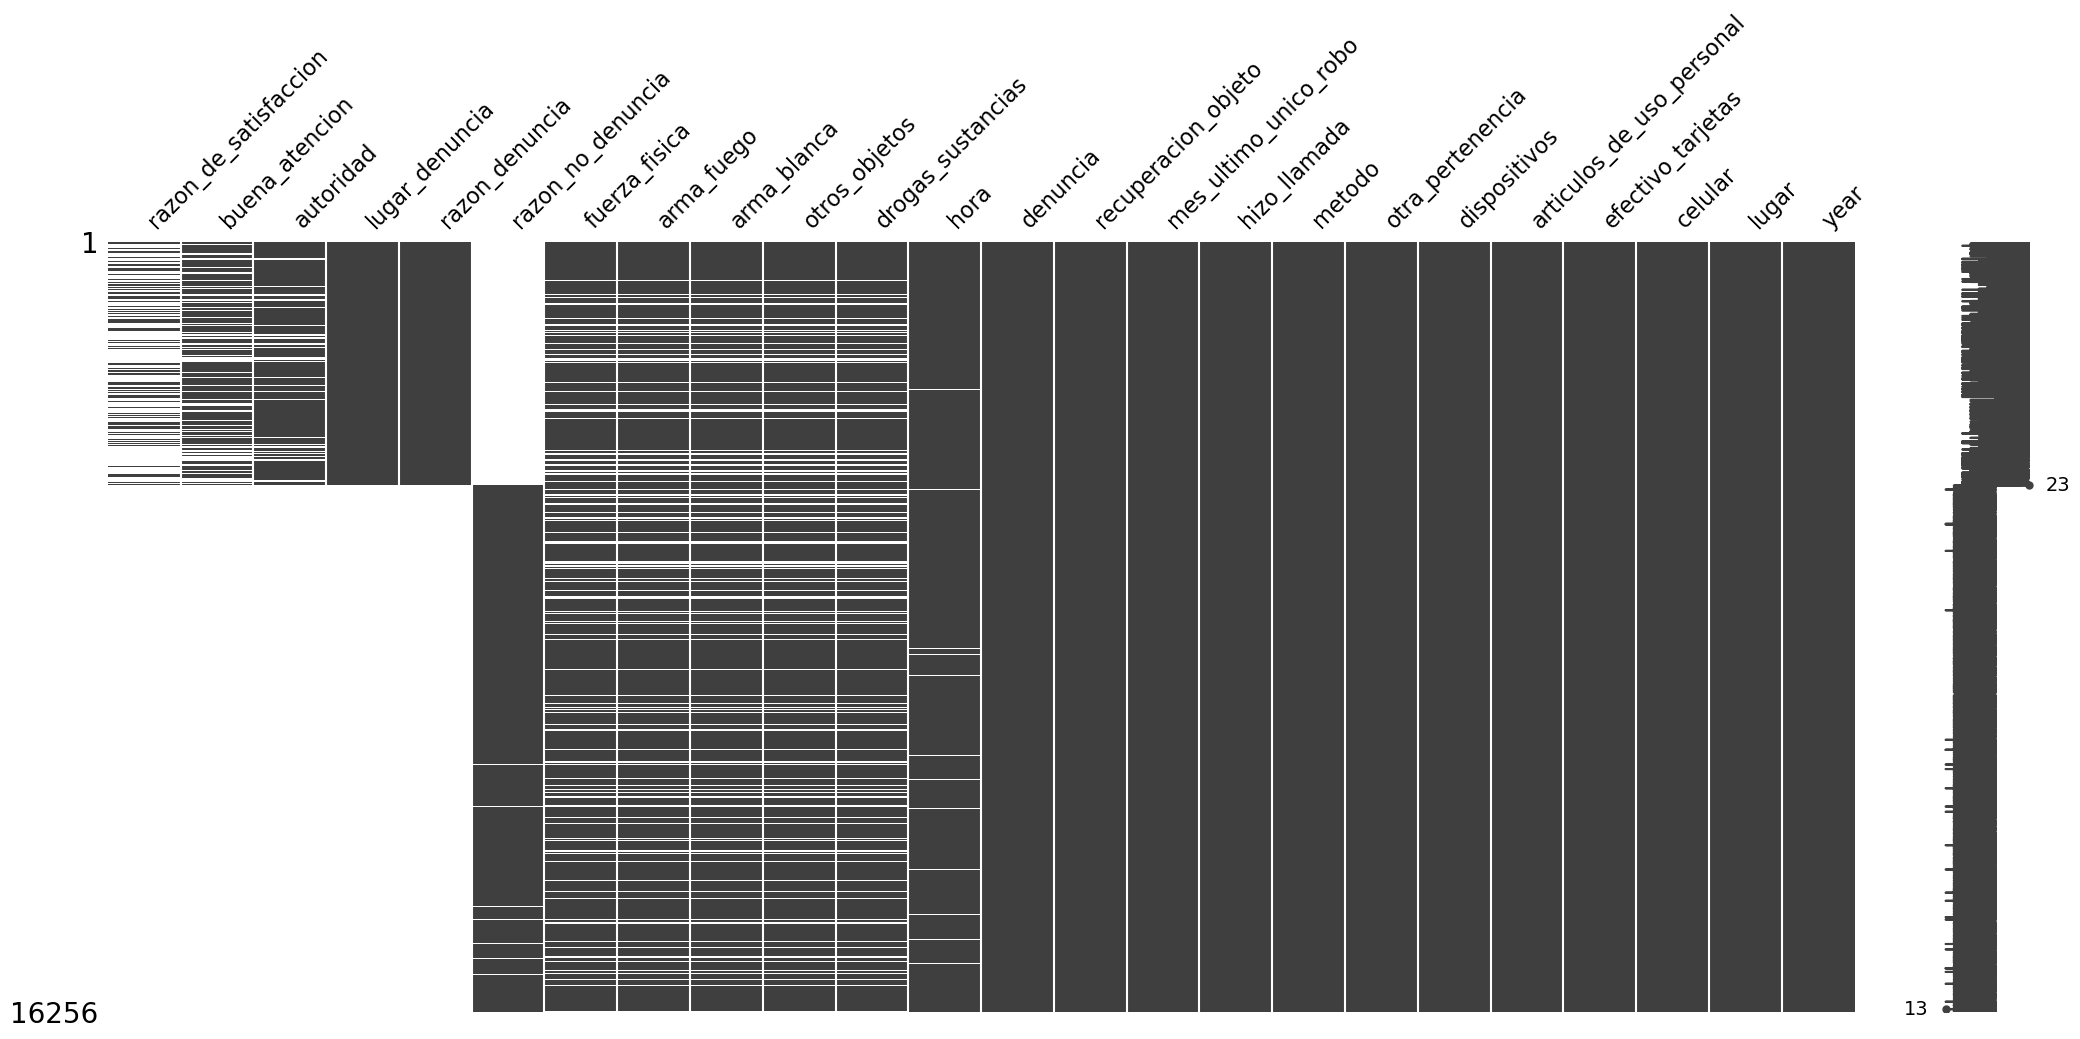

In [180]:
(
    df
    .ms_tools.sort_variables_by_missingness()
    .sort_values(by='razon_denuncia')
    .pipe(missingno.matrix)
)

### Hipótesis - valores faltantes por denuncia
Al crear la anterior visualización pensé en que la falta de valores
dependía de si la persona hizo o no la denuncia de su objeto robado.
Por eso, decido separar a las personas que denunciaron en un dataset y las 
que no en otro:

In [181]:
df_si_denuncia = df[df['denuncia']=='si']
df_no_denuncia = df[df['denuncia']=='no']

## Valores faltantes de las personas que no denunciaron

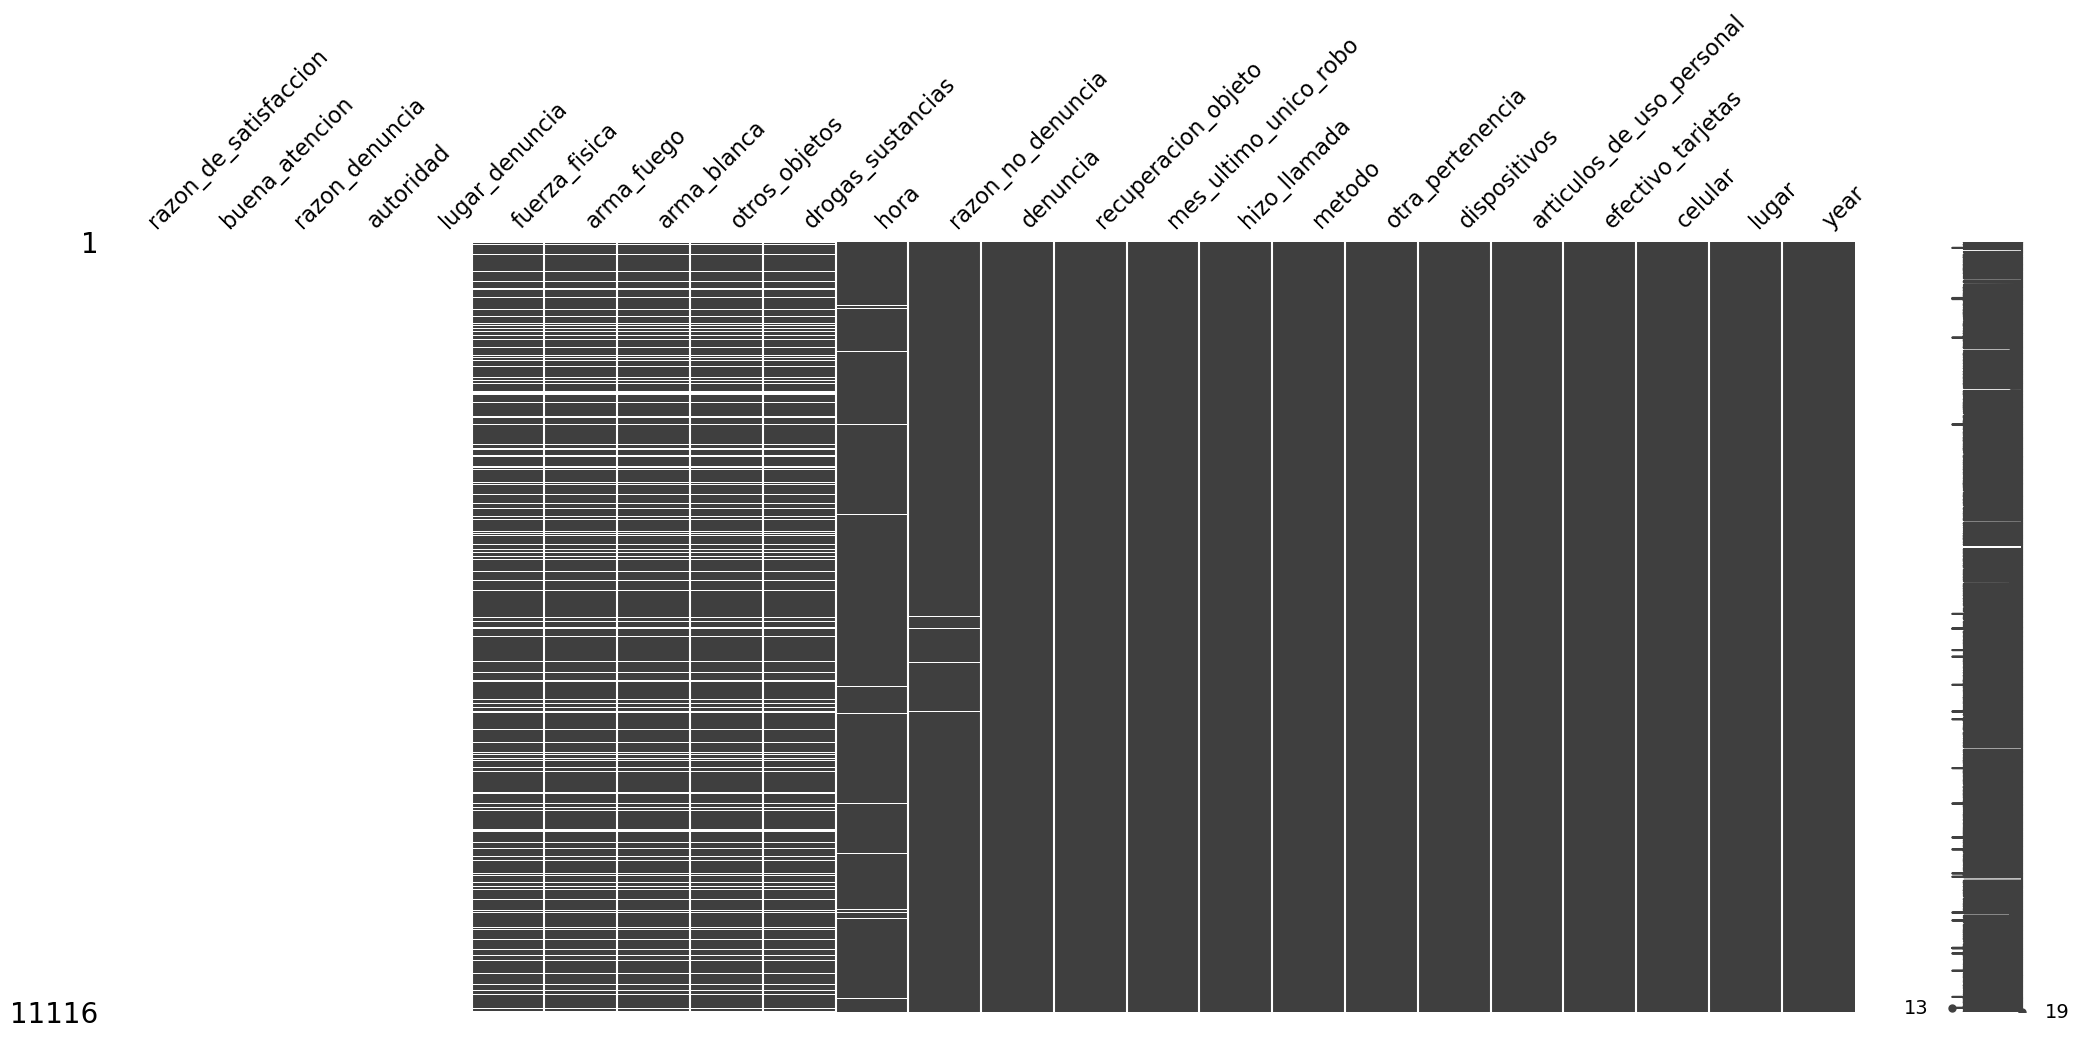

In [182]:
#valores faltantes de personas que no denunciaron
(
    df_no_denuncia
    .ms_tools.sort_variables_by_missingness()
    .sort_values(by='razon_denuncia')
    .pipe(missingno.matrix)
)
plt.show()

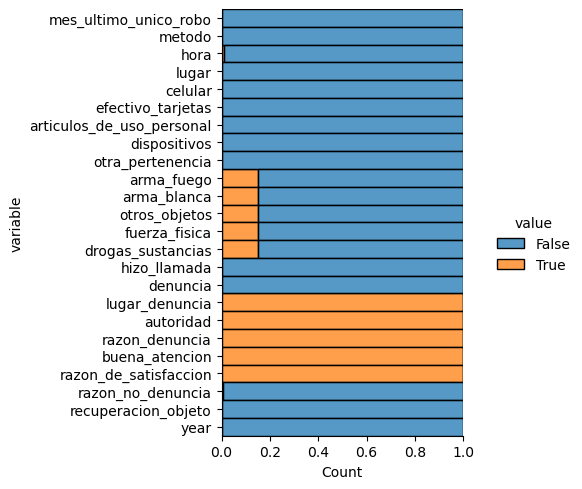

In [183]:
df_no_denuncia.ms_tools.vis_proportion()
plt.show()

### imputación de valores en personas que no denunciaron
Debido al conocimiento del contexto: los valores faltantes de este dataset se deben a que
las personas no hicieron una denuncia.
procedo a rellenar estos valores faltantes (naranjas) por el valor "no_denuncia"
para más adelante tener un mejor análisis de la información

In [184]:
values_to_fill = {
    'lugar_denuncia':'no_denuncia',
    'autoridad':'no_denuncia',
    'razon_denuncia':'no_denuncia',
    'buena_atencion':'no_denuncia',
    'razon_de_satisfaccion':'no_denuncia'
    }

In [185]:
df_no_denuncia = df_no_denuncia.fillna(value=values_to_fill)

## valores nulos de las personas que si denunciaron

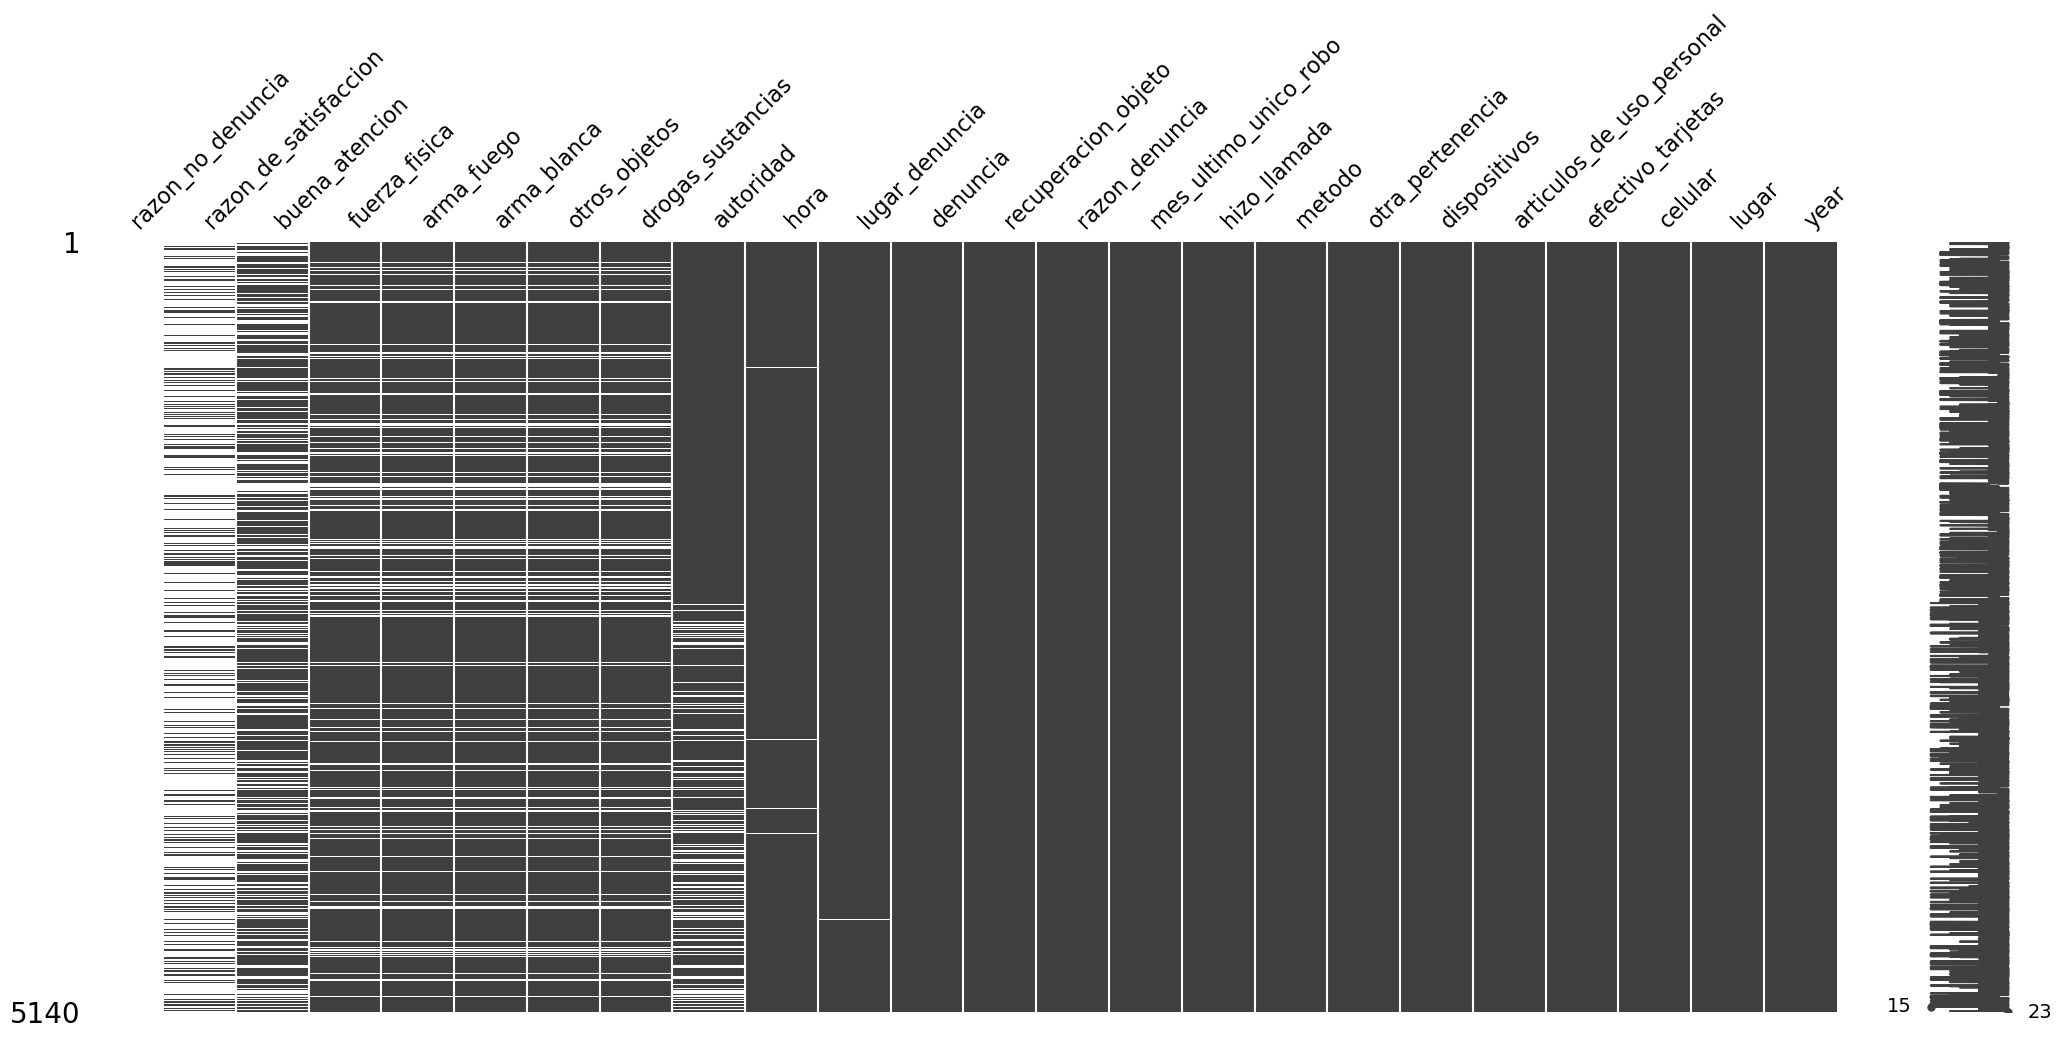

In [186]:
(
    df_si_denuncia
    .ms_tools.sort_variables_by_missingness()
    .sort_values(by='razon_no_denuncia')
    .pipe(missingno.matrix)
)
plt.show()

In [187]:
print('valor que tiene la columna denuncia en este data set:',df_si_denuncia.denuncia.unique())

valor que tiene la columna denuncia en este data set: ['si']


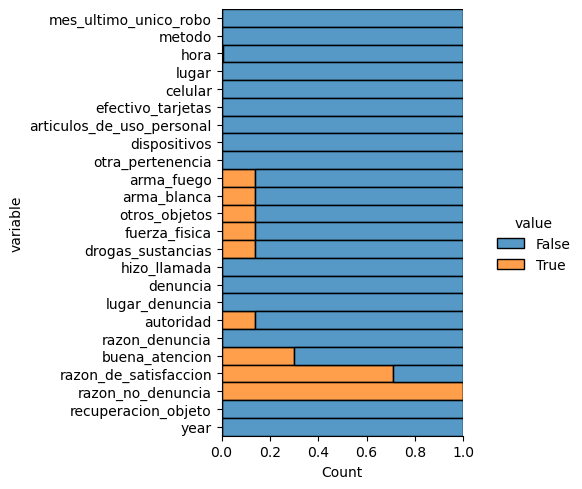

In [188]:
df_si_denuncia.ms_tools.vis_proportion()

### imputación de valores
Debido al conocimiento del contexto: Los valores faltantes de la columna "razon_no_denuncia"
de este dataset se debe a que las personas si denunciaron.
Por eso voy a rellenar los valores faltantes por la palabra "si denuncia" para luego en
el ejercicio del análisis saber que estos valores solo faltaron porque las personas si
denunciaron:

In [189]:
df_si_denuncia = df_si_denuncia.fillna(value={'razon_no_denuncia':'si_denuncia'})

### Nuevo DataFrame sin los valores nulos de las personas que no hicieron denuncia

In [190]:
new_df = pd.concat([df_no_denuncia,df_si_denuncia])

In [191]:
#veamos que si tengan los mismos datos
print(df.shape,new_df.shape,sep='\n')

(16256, 24)
(16256, 24)


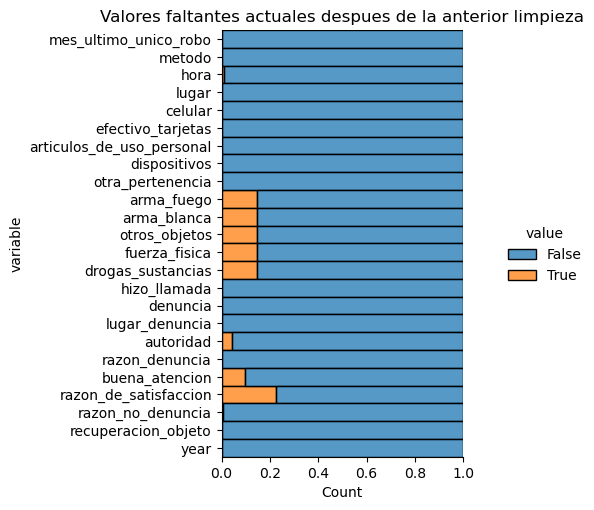

In [192]:
new_df.ms_tools.vis_proportion()
plt.title("Valores faltantes actuales despues de la anterior limpieza")
plt.show()

In [193]:
new_df.ms_tools.table_variable_summary()

,variable,n_missing,n_cases,pct_missing
0,mes_ultimo_unico_robo,0,16256,0.000000
1,metodo,0,16256,0.000000
2,hora,145,16256,0.891978
3,lugar,0,16256,0.000000
4,celular,0,16256,0.000000
5,efectivo_tarjetas,0,16256,0.000000
6,articulos_de_uso_personal,0,16256,0.000000
7,dispositivos,0,16256,0.000000
8,otra_pertenencia,0,16256,0.000000
9,arma_fuego,2372,16256,14.591535


# ¿Qué factores existen para que falten valores en los objetos que utilizaron en el hurto?:

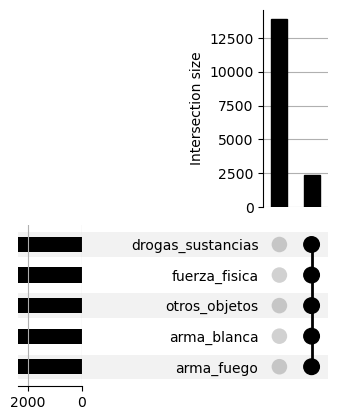

In [194]:
new_df.ms_tools.vis_upsetplot(variables=['arma_fuego', 'arma_blanca', 'otros_objetos',
       'fuerza_fisica', 'drogas_sustancias'])
plt.show()

### Hipótesis - Los valores faltantes en el tipo de arma tal vez se deba al metodo

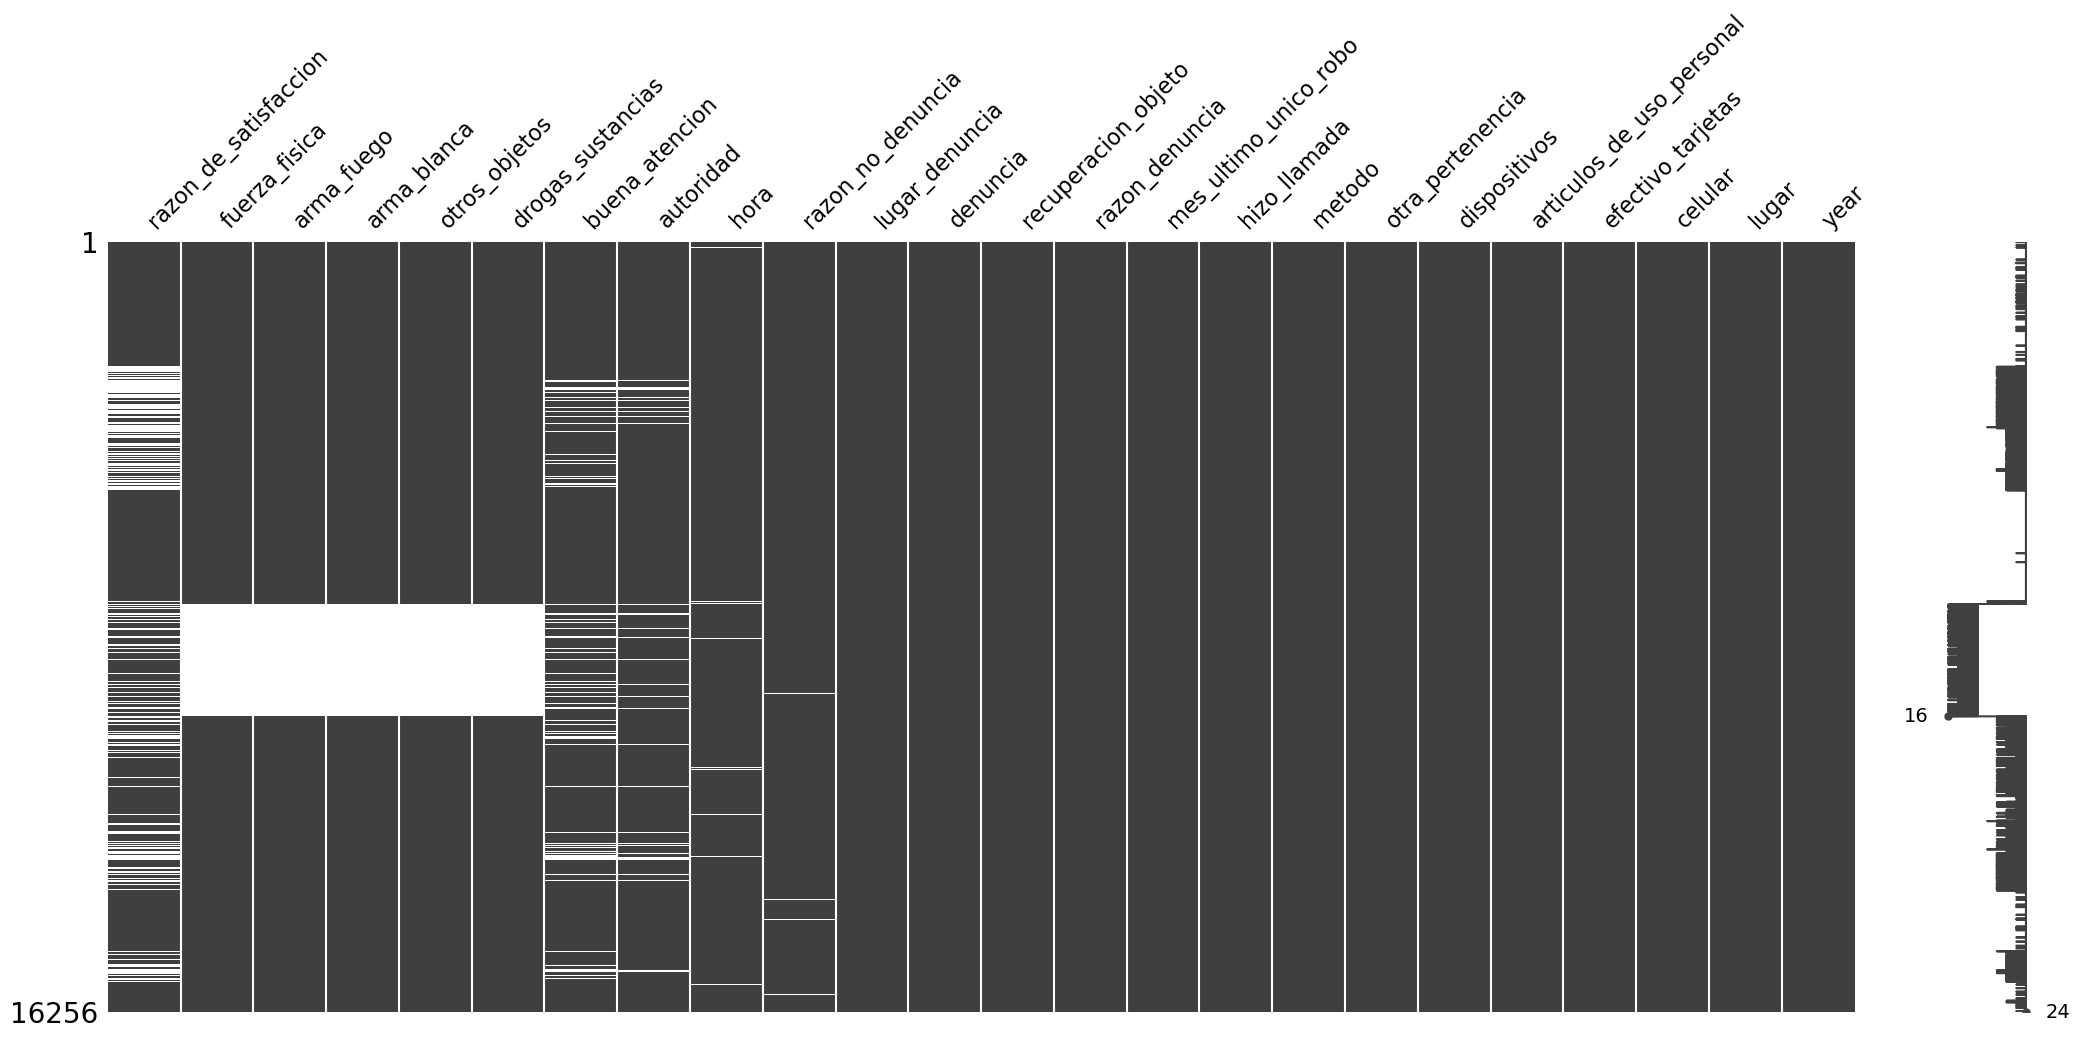

In [195]:
(
    new_df
    .ms_tools
    .sort_variables_by_missingness()
    .sort_values(by='metodo')
    .pipe(missingno.matrix)
)
plt.show()

In [196]:
#Con esto comprobamos que los valores faltantes se deben al tipo de hurto
#cosquilleo 
df_metodo_nulos = new_df[new_df.arma_fuego.isnull()]
df_metodo_nulos.metodo.unique()

array(['cosquilleo'], dtype=object)

#### Observaciones:
Vemos que los valores faltantes de los objetos utilizados para el robo son debido al metodo
de hurto en este caso cosquilleo, por lo cual las victimas no pudierón responder a esta pregunta.
Sin embargo y sabiendo el contexto del metodo de robo, decido imputar el valor "no" en todas las columnas
ya que este metodo no implica ninguna de estas armas u objetos para robar.

In [197]:
new_df = new_df.fillna(value={
    'arma_fuego':'no',
    'arma_blanca':'no',
    'otros_objetos':'no',
    'fuerza_fisica':'no',
    'drogas_sustancias':'no'
    })

# ¿Qué puede seguir influyendo en los valores nulos?

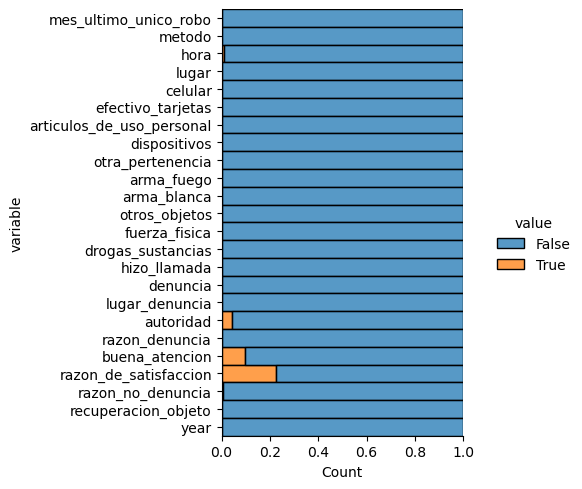

In [198]:
new_df.ms_tools.vis_proportion()

In [199]:
new_df.ms_tools.table_variable_summary()

,variable,n_missing,n_cases,pct_missing
0,mes_ultimo_unico_robo,0,16256,0.000000
1,metodo,0,16256,0.000000
2,hora,145,16256,0.891978
3,lugar,0,16256,0.000000
4,celular,0,16256,0.000000
5,efectivo_tarjetas,0,16256,0.000000
6,articulos_de_uso_personal,0,16256,0.000000
7,dispositivos,0,16256,0.000000
8,otra_pertenencia,0,16256,0.000000
9,arma_fuego,0,16256,0.000000


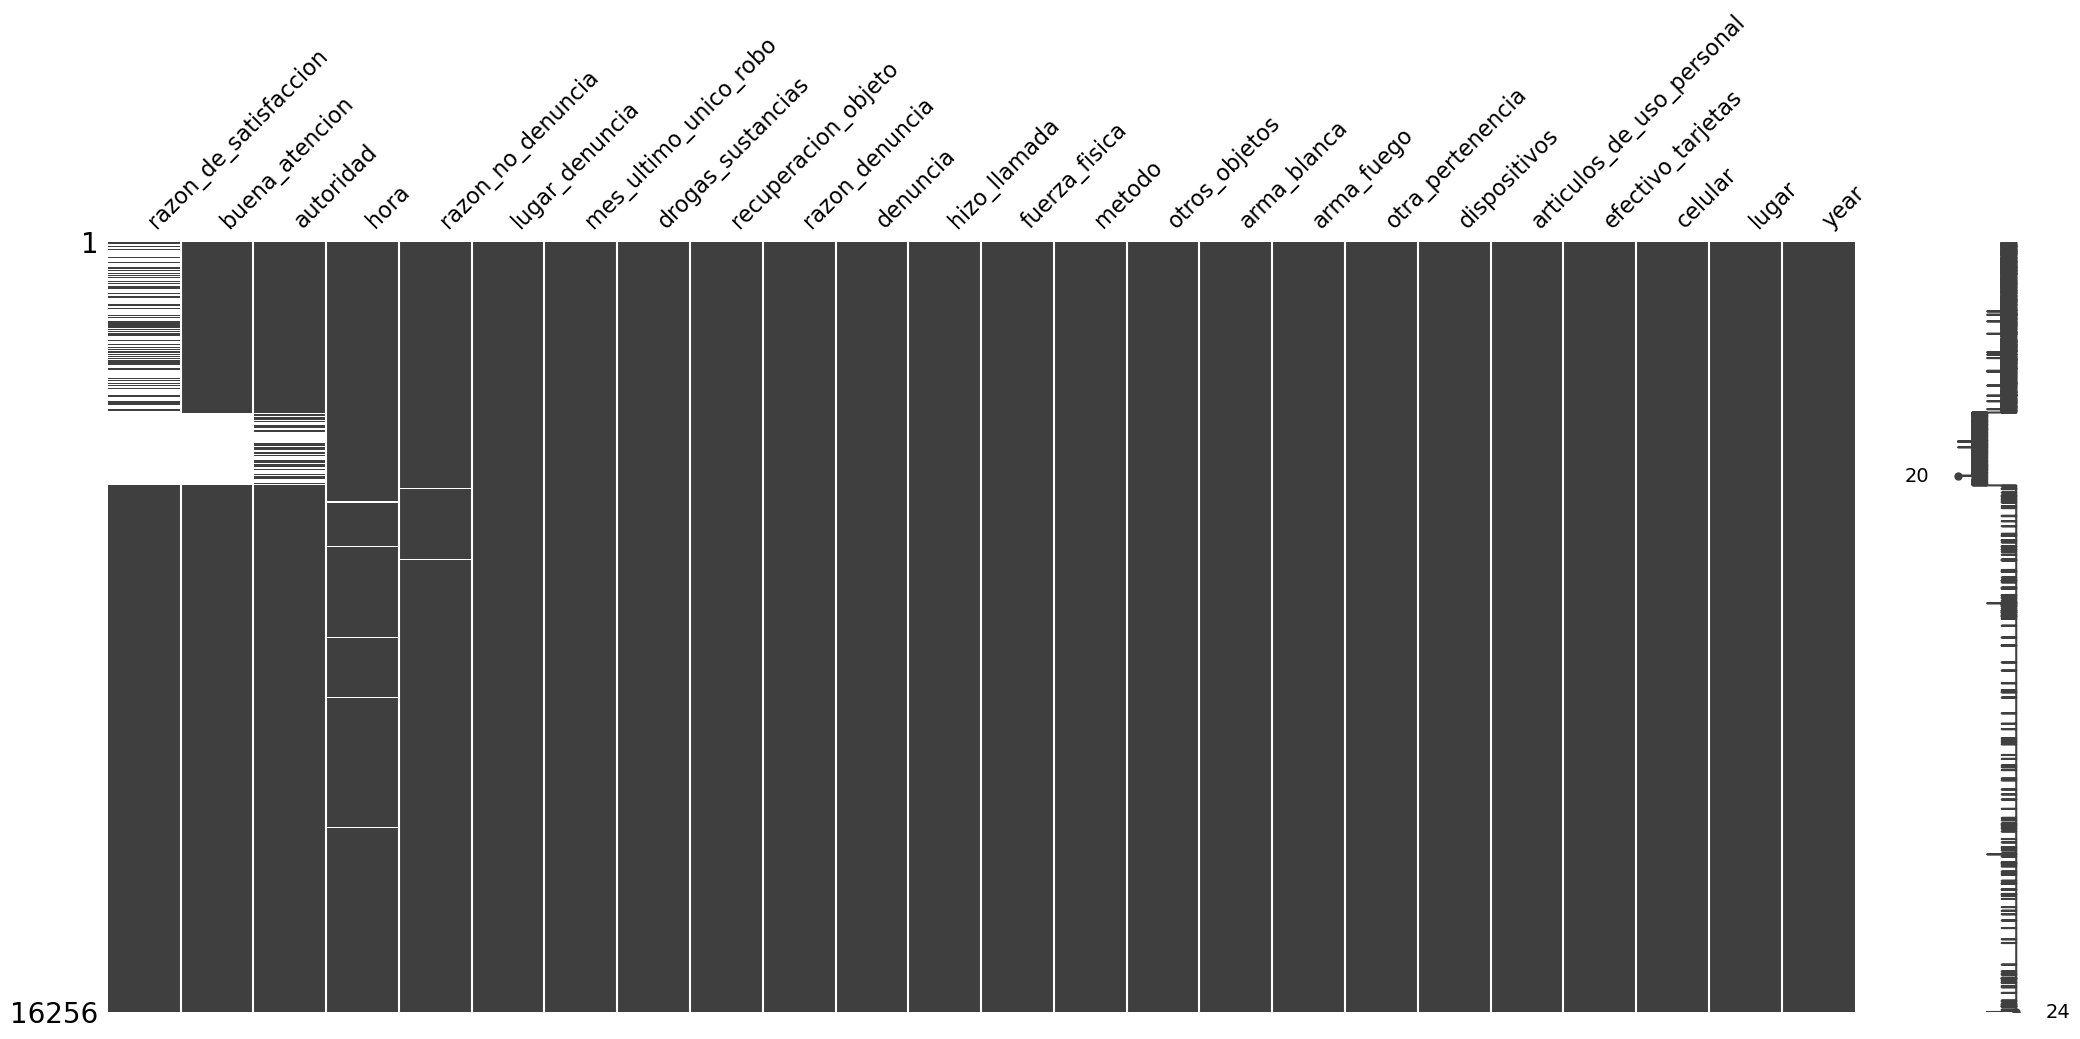

In [200]:
(
    new_df
    .ms_tools
    .sort_variables_by_missingness()
    .sort_values(by='lugar_denuncia')
    .pipe(missingno.matrix)
)
plt.show()

### Hipotesis - lugar donde se denuncia
Vemos que al clasificar los valores faltantes en el lugar de denuncia se acumulan. Esto puede ser porque estos valores faltantes se deben al lugar en donde se hace la denuncia que en este caso podría ser página web y por ello las personas no respondieron si hubo una buena o mala atención del servidor público.


In [201]:
#Comprobando que los valores nulos de si recibieron buena atencion se deba a que las denuncias
#se hicieron por internet
df_denuncias_internet = new_df[new_df.buena_atencion.isnull()]
df_denuncias_internet.lugar_denuncia.unique()

array(['denuncias en línea', 'Reporte de objetos perdidos en línea'],
      dtype=object)

In [202]:
df_denuncias_presenciales = new_df[new_df.buena_atencion.notnull()]
df_denuncias_presenciales.lugar_denuncia.unique()


array(['no_denuncia', 'Fiscalía', 'Estación de Policía', 'C.A.I.', nan],
      dtype=object)

### Denuncias online

In [203]:
print('df_size:',new_df.shape,
      'denuncias online:',
      df_denuncias_internet.shape,
      'denuncias presenciales:',
      df_denuncias_presenciales.shape,sep='\n')

df_size:
(16256, 24)
denuncias online:
(1539, 24)
denuncias presenciales:
(14717, 24)


### Observaciones:
Comprobamos la hipótesis y los valores faltantes de estos valores se deben a que la denuncia fue presentada
en el sitio web. sin embargo los valores faltantes en autoridad como vemos, no necesariamente faltan por que la denuncia haya sido hecha en el sitio web como vemos en la siguiente grafica:

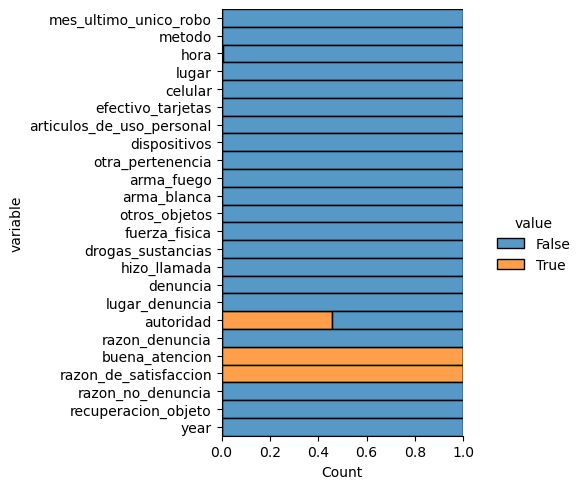

In [204]:
df_denuncias_internet.ms_tools.vis_proportion()

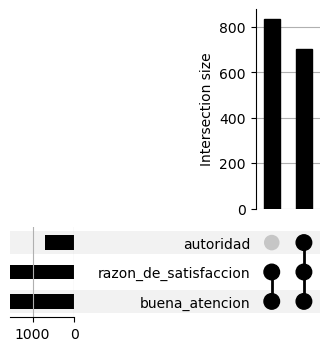

In [205]:
df_denuncias_internet.ms_tools.vis_upsetplot(variables=['autoridad','buena_atencion','razon_de_satisfaccion'])
plt.show()

### Denuncias presenciales

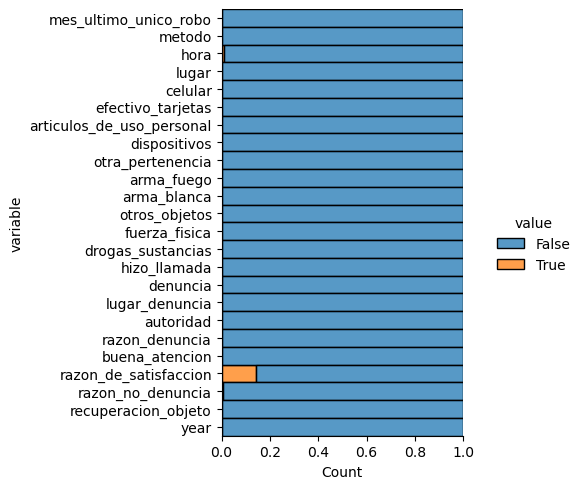

In [206]:
df_denuncias_presenciales.ms_tools.vis_proportion()

#### Imputación de datos

Vemos que los valores nulos de la razon y denuncia y razon de satisfaccion tienen correlacion con el
lugar donde se hizo la denuncia que es online, por ello rellenare esos valores con "denuncia_online" 

In [207]:
df_denuncias_internet = df_denuncias_internet.fillna(
        value={
            'buena_atencion':'denuncia_online',
            'razon_de_satisfaccion':'denuncia_online'
            }
    )

In [208]:
pre_final_df = pd.concat([df_denuncias_internet,df_denuncias_presenciales])

## últimos valores nulos

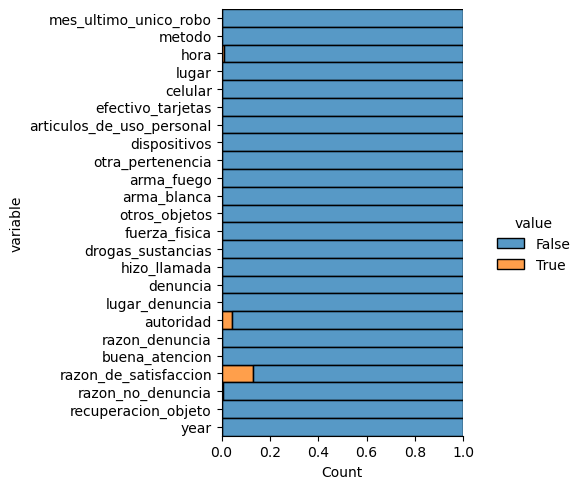

In [209]:
pre_final_df.ms_tools.vis_proportion()

In [210]:
pre_final_df.ms_tools.table_variable_summary()

,variable,n_missing,n_cases,pct_missing
0,mes_ultimo_unico_robo,0,16256,0.000000
1,metodo,0,16256,0.000000
2,hora,145,16256,0.891978
3,lugar,0,16256,0.000000
4,celular,0,16256,0.000000
5,efectivo_tarjetas,0,16256,0.000000
6,articulos_de_uso_personal,0,16256,0.000000
7,dispositivos,0,16256,0.000000
8,otra_pertenencia,0,16256,0.000000
9,arma_fuego,0,16256,0.000000


### Hipótesis - A recordar
- Los valores faltantes de la hora recordamos que en la encuestan existían usuarios que no quisieron responder la pregunta o no sabían la hora en la que ocurrió el robo.

- En razon no denuncia hay que recordar que habían valores(10.) que no tenían ninguna equivalencia con preguntas de la encuesta por lo tanto no podía darles un valor.



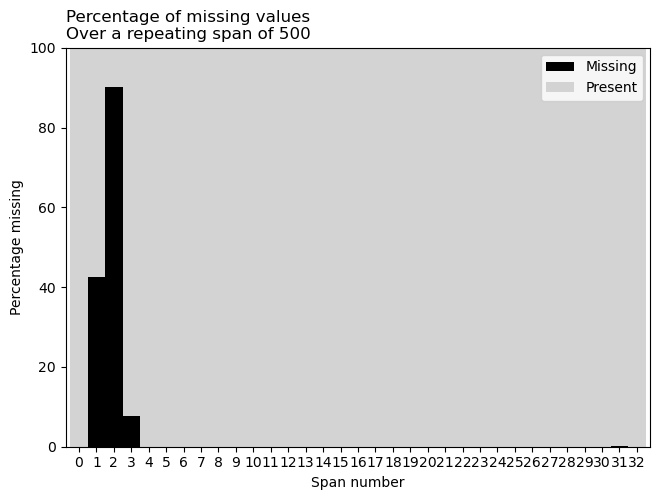

In [211]:
pre_final_df.ms_tools.vis_variable_span_plot(variable='autoridad',span_every=500)

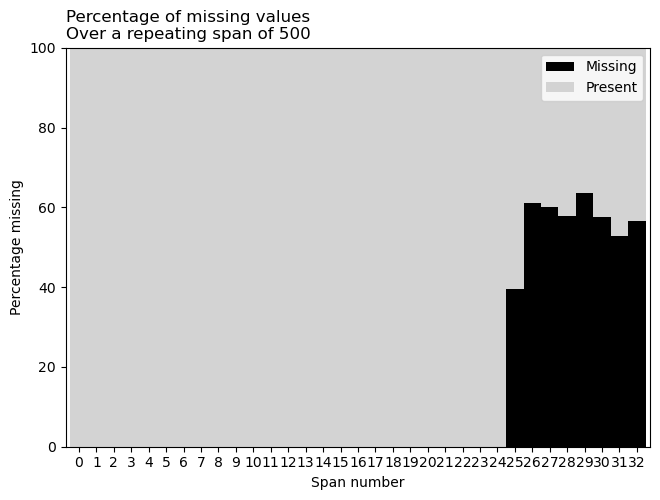

In [212]:
pre_final_df.ms_tools.vis_variable_span_plot(variable='razon_de_satisfaccion',span_every=500)

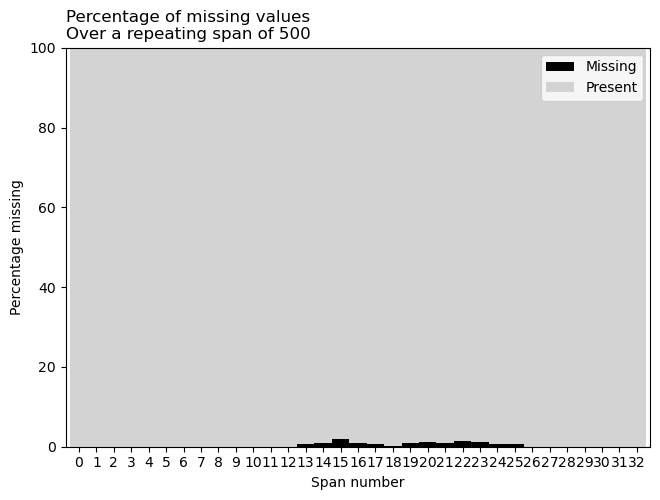

In [213]:
pre_final_df.ms_tools.vis_variable_span_plot(variable='razon_no_denuncia',span_every=500)

# Nota final
por el momento no logro encontra las razones de estos valores faltantes, por ello optare por seguir con el proyecto conservandolos en el dataset

# Exportacion dataset

In [214]:
df_processed = pre_final_df.copy()

In [215]:
df_processed.to_csv(
    path_or_buf=data_dir("processed","hurtos_processed.csv"),
    index=False,
    sep=','
)